In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

In [49]:
class SigmoidActivation:
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def backward(self, d_activation, pre_activation):
        sigmoid_derivative = self.__call__(pre_activation) * (1 - self.__call__(pre_activation))
        return d_activation * sigmoid_derivative


In [50]:
class SoftmaxActivation:
    def __call__(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtracting max for numerical stability
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)


In [51]:
class MLP_Layer:
    def __init__(self, activation_function, input_size, num_units):
        self.activation = activation_function
        self.weights = np.random.normal(loc=0.0, scale=0.2, size=(input_size, num_units))
        self.biases = np.zeros(num_units)

    def forward(self, x):
        self.input = x
        self.pre_activation = np.dot(x, self.weights) + self.biases
        self.activation_output = self.activation(self.pre_activation)
        return self.activation_output

    def backward_weights(self, grad_pre_activation):
        dL_dW = np.dot(self.input.T, grad_pre_activation)
        dL_dinput = np.dot(grad_pre_activation, self.weights.T)
        return dL_dW, dL_dinput


In [52]:
class CategoricalCrossEntropyLoss:
    def __call__(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(y_true * np.log(y_pred)) / len(y_true)
        self.y_true = y_true
        self.y_pred = y_pred
        return loss

    def backward(self): #shapes: prediction(minibatch_size, 10) loss(minibatch_size,1)
      #for CCE and Softmax
      delta = self.y_pred - self.y_true
      return delta

In [53]:
class MLP:
    def __init__(self, layer_sizes, activation_functions):
        self.num_layers = len(layer_sizes)
        self.layers = []

        for i in range(1, self.num_layers):
            layer = MLP_Layer(activation_functions[i - 1], layer_sizes[i - 1], layer_sizes[i])
            self.layers.append(layer)

    def forward(self, x):
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def backward(self, y_true, grad_loss):
        gradients_list = [{} for _ in range(self.num_layers - 1)]
        grad_activation = grad_loss

        for i in reversed(range(self.num_layers - 1)):
          if isinstance(self.layers[i].activation, SoftmaxActivation):
            gradients_list[i]['grad_pre_activation'] = grad_loss
            gradients_list[i]['grad_weights'], grad_activation = self.layers[i].backward_weights(
                gradients_list[i]['grad_pre_activation']
            )
          else:
            gradients_list[i]['grad_pre_activation'] = self.layers[i].activation.backward(
                grad_activation, self.layers[i].pre_activation
            )
            gradients_list[i]['grad_weights'], grad_activation = self.layers[i].backward_weights(
                gradients_list[i]['grad_pre_activation']
            )


        for i in range(self.num_layers - 1):
            self.layers[i].weights -= learning_rate * gradients_list[i]['grad_weights']

        return gradients_list

In [54]:
def shuffle_data(data, labels):
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    return data[indices], labels[indices]

In [55]:
def generate_minibatches(data, labels, minibatch_size):
    for i in range(0, len(data), minibatch_size):
        yield data[i:i+minibatch_size], labels[i:i+minibatch_size]


In [56]:
def train_mlp(mlp, train_data, train_labels, learning_rate, epochs, minibatch_size):
    losses = []

    for epoch in range(epochs):
        train_data, train_labels = shuffle_data(train_data, train_labels)
        avg_loss = 0.0

        for minibatch_data, minibatch_labels in generate_minibatches(train_data, train_labels, minibatch_size):
            # Forward pass
            output_data = mlp.forward(minibatch_data)
            cross_entropy_loss = CategoricalCrossEntropyLoss()
            loss_value = cross_entropy_loss(minibatch_labels, output_data)

            # Backward pass
            grad_loss = cross_entropy_loss.backward()
            gradients_list = mlp.backward(minibatch_labels, grad_loss)

            # Update weights
            for i in range(mlp.num_layers - 1):
                mlp.layers[i].weights -= learning_rate * gradients_list[i]['grad_weights']

            avg_loss += loss_value / len(train_data)

        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

    # Plot the results
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss vs. Epoch')

    plt.show()

In [57]:
# Load the handwritten digits dataset (using load_digits from sklearn)
digits = load_digits()

# Split the data into features and labels
data = digits.data # 1797 x 64
labels = digits.target # 1797 x 1

data_scaled = (data - np.min(data)) / (np.max(data) - np.min(data))

# One-hot encode the labels
labels_onehot = np.eye(10)[labels]

Epoch 1/100 - Loss: 0.0736
Epoch 2/100 - Loss: 0.0699
Epoch 3/100 - Loss: 0.0671
Epoch 4/100 - Loss: 0.0641
Epoch 5/100 - Loss: 0.0605
Epoch 6/100 - Loss: 0.0570
Epoch 7/100 - Loss: 0.0529
Epoch 8/100 - Loss: 0.0490
Epoch 9/100 - Loss: 0.0452
Epoch 10/100 - Loss: 0.0414
Epoch 11/100 - Loss: 0.0381
Epoch 12/100 - Loss: 0.0348
Epoch 13/100 - Loss: 0.0320
Epoch 14/100 - Loss: 0.0294
Epoch 15/100 - Loss: 0.0274
Epoch 16/100 - Loss: 0.0253
Epoch 17/100 - Loss: 0.0235
Epoch 18/100 - Loss: 0.0221
Epoch 19/100 - Loss: 0.0206
Epoch 20/100 - Loss: 0.0194
Epoch 21/100 - Loss: 0.0186
Epoch 22/100 - Loss: 0.0176
Epoch 23/100 - Loss: 0.0164
Epoch 24/100 - Loss: 0.0157
Epoch 25/100 - Loss: 0.0152
Epoch 26/100 - Loss: 0.0143
Epoch 27/100 - Loss: 0.0138
Epoch 28/100 - Loss: 0.0132
Epoch 29/100 - Loss: 0.0128
Epoch 30/100 - Loss: 0.0122
Epoch 31/100 - Loss: 0.0118
Epoch 32/100 - Loss: 0.0114
Epoch 33/100 - Loss: 0.0110
Epoch 34/100 - Loss: 0.0107
Epoch 35/100 - Loss: 0.0104
Epoch 36/100 - Loss: 0.0103
E

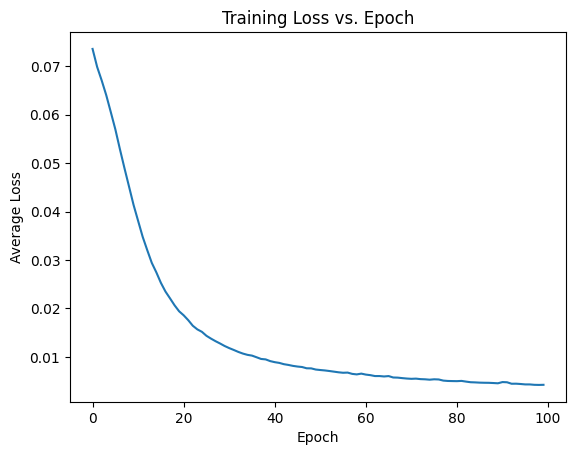

In [58]:
# Define the MLP architecture and train the model
mlp = MLP(layer_sizes=[64, 32, 10], activation_functions=[SigmoidActivation(), SoftmaxActivation()])
learning_rate = 0.001
epochs = 100
minibatch_size = 32

train_mlp(mlp, data_scaled, labels_onehot, learning_rate, epochs, minibatch_size)
